# K-means con iris dataset desde scratch
Vamos a trabajar solo con los datos ancho y largo de pétalo.

Comenzamos graficando el dataset etiquetado.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['especies'] = iris['target']
colores = ['green', 'blue', 'orange']
especies = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
marcador=['o','s','^']


for i in range(0, 3):    
    especies_df = iris_df[iris_df['especies'] == i]    
    plt.scatter(especies_df['petal length (cm)'], especies_df['petal width (cm)'], color=colores[i], label=especies[i], marker=marcador[i])

plt.xlabel('Longitud petalo (cm)')
plt.ylabel('Ancho petalo (cm)')
plt.title('Iris dataset')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

Si quitamos las etiquetas tenemos algo como lo siguiente.

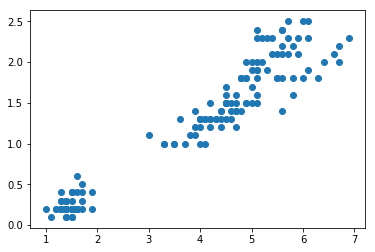

In [2]:
plt.scatter(iris_df['petal length (cm)'], iris_df['petal width (cm)'])
plt.show()

Acondicionamos los datos para ingresarlos a nuestro algoritmo

In [3]:
longitud_petalo=list(iris_df['petal length (cm)'])
ancho_petalo=list(iris_df['petal width (cm)'])

lista_datos_petalos= [list(x) for x in zip(longitud_petalo,ancho_petalo)]
#trabajamos los datos como un arreglo de numpy con shape [150,2]
datos_petalos= np.array(lista_datos_petalos)

Definimos la funcion para obtener la distancia euclidiana la cual será una funcion global.

In [4]:
def distancia_euclidiana(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

Comenzamos con la implementación del algoritmo K-means

In [5]:
class K_Means():

    def __init__(self, k=5, iteraciones_max=100, paso_grafica=False):
        self.k = k #Numero de clusters, por defecto 5
        self.iteraciones_max = iteraciones_max #Numero máximo de iteraciones
        self.paso_grafica = paso_grafica #Quiero ver cada paso? Es decir cada gráfica de cada iteracion

        self.clusters = [[] for i in range(self.k)] #Almacenamos los clusters
        self.centroides = [] #Almacenamos los centroides

    #No tenemos método fit porque al ser aprendizaje no supervisado no necesitamos etiquetas
    def predict(self, datos):
        self.datos = datos #Datos
        self.numero_datos, self.numero_columnas = datos.shape #Dimensiones [150,2]
        
        #Inicializamos los centroides aleatorios
        #Elegimos indices aleatorios de numero_datos
        indices_aleatorios = np.random.choice(self.numero_datos, self.k, replace=False) #Arreglo de tamaño k, replace=False porque no queremos datos repetidos
        self.centroides = [self.datos[indice] for indice in indices_aleatorios] #Lista con 3 parejas de numeros salidos de nuestros datos

        # Optimizamos los clusters
        # Un ciclo for que hace las iteraciones que le indiquemos 
        for i in range(self.iteraciones_max):
            # Assign samples to closest centroides (create clusters)
            self.clusters = self.crear_clusters(self.centroides)
            
            if self.paso_grafica:
                self.visulaizar()

            #Una vez creados los clusters hasy que sacar la media de las distancias y asignar un nuevo centroide 
            #Guardamos los datos anteriores en una variable
            centroides_anteriores = self.centroides
            #Asignamos los centroides calculados a nuestra variable
            self.centroides = self.obtener_centroides_calculados(self.clusters)
            
            # revisamos si nuestro algoritmo ya convergió
            #en caso afirmativo terminamos el algoritmo
            if self.convergencia(centroides_anteriores, self.centroides):
                break

            if self.paso_grafica:
                self.visulaizar()

        # Obtenemos la etiqueta del cluster al cual fue asignado
        return self.obtener_etiquetas_clusters(self.clusters)

    #Funcion que nos regresa la etiqueta del cluster al que fue asignado cada dato
    def obtener_etiquetas_clusters(self, clusters):
        #hacemos un arreglo vacio de tamaño del numero de datos que tenemos
        #Es decir el indice del cluster al que fue asignado
        etiquetas = np.empty(self.numero_datos)

        #recorremos el arreglo clusters el cual contiene los indices de los elementos en cada cluster
        #es una lista de listas
        for indice_cluster, cluster in enumerate(clusters):
            #recorremos cada indice 
            for indice_muestra in cluster:
                #Metemos las etiquetas de cada pareja de datos
                etiquetas[indice_muestra] = indice_cluster
        return etiquetas

    #En esta funcion asignamos los puntos al centroide más cercano
    def crear_clusters(self, centroides):
        #Lista que contendra lis indices de los elementos de cada cluster
        clusters = [[] for i in range(self.k)]
        #enumerate le ponde un indice visible a cada dato en datos
        # (0,[2,4]),(1,[3,8])
        for indice, muestra in enumerate(self.datos):
            #Asignamos a indice_centroide el centroide más cercano utilizando la funcion que calcula la distancia entre los puntos
            #A la fucion le pasamos los puntos y los centroides
            indice_centroide = self.centroide_cercano(muestra, centroides)
            #En nuestra lista clusters agregamos cada indice
            clusters[indice_centroide].append(indice)
        return clusters

    #En esta funcion calculamos la distancia de cad apunto a su centroide 
    def centroide_cercano(self, muestra, centroides):
        #Calculamos las distancias euclidianas a los puntos y las guardamos en una lsita de nombre distancias
        distancias = [distancia_euclidiana(muestra, punto) for punto in centroides]
        #Con argmin seleccionamos el indice del valor más bajo en distancias y lo guardamos en centroide_indice_cercano
        centroide_indice_cercano = np.argmin(distancias)
        #Regresamos el indice
        return centroide_indice_cercano

    #Funcion que calcula la media de las distancias y asigna los centroides calculados
    def obtener_centroides_calculados(self, clusters):
        #centroides es un arreglo lleno de ceros de tamaño 3 y dos columnas
        # [[x,y],[x,y],[x,y]]
        centroides = np.zeros((self.k, self.numero_columnas))
        #Enumeramos cada cluster y lo iteramos
        #recordemos que clusters es una lista de listas 
        for indice_cluster, cluster in enumerate(clusters):
            #cluster es una lista de los indices de los elementos pertenecientes al cluster 
            #con np.mean() calculamos la media 
            #usamos datos[cluster] para llamar a la pareja de datos de la cual se sacará la media
            promedio_cluster = np.mean(self.datos[cluster], axis=0)
            #una vez calculada la media de cada cluster se lo asignamos a los centroides
            centroides[indice_cluster] = promedio_cluster
        return centroides

    #funcion que revisa la convergencia de los centroides
    #Es decir cuando la distancia entre centroides_anteriores y centroides es 0
    def convergencia(self, centroides_anteriores, centroides):
        #asignamos a un arreglo de distancias 
        distancias = [distancia_euclidiana(centroides_anteriores[i], centroides[i]) for i in range(self.k)]
        #sumamos el arreglo y si es 0 entonces nuestro algoritmo convergió
        #regresa un true o false
        return sum(distancias) == 0

    def visulaizar(self):
        self.fig= plt.figure()
        self.ax = self.fig.add_subplot(1,1,1)

        for i, indice in enumerate(self.clusters):
            #print(self.datos[indice])
            #print('**********************')
            #print(self.datos[indice])
            # Utilizar el .T divide nuestra lista de listas inicial en dos listas separadas
            punto = self.datos[indice].T
            
            #Utilizar *punto le dice a nuestra funcion que le estamos pasando una lista con x y otra con y 
            #dentro de la misma variable
            self.ax.scatter(*punto)
            
        for punto in self.centroides:
            self.ax.scatter(*punto, marker="x", color='black', linewidth=2)
            
        plt.xlabel('Longitud del petalo')
        plt.ylabel('Ancho del petalo')
        plt.show()
    
        


Creamos la instancia de nuestro algoritmo y lo probamos.

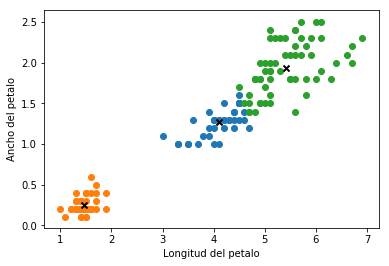

In [6]:
kMeans=K_Means(k=3, iteraciones_max=10, paso_grafica=False)
kMeans.predict(datos_petalos)
kMeans.visulaizar()

## ¿Qué pasa si no tenemos el número de clusters?
El metodo elbow o gráfica de codo nos permite determinar el número adecuado de clusters para que nuestras distancias a los centroides no sean ni muy grandes ni muy pequeñas.

Este método consiste en correr el algoritmo de k-means variando el número de clusters asignados y para cada ejecucion se calcula la inercia (también es posible hacerlo con la suma de las distancias al cuadrado) de cada punto a su centroide asignado, a esto se le llama distorción.

Una vez graficada la distorción contra el número de clusters podemos ver una gráfica que toma la forma de un codo, de la cual su punto de inflexion nos indica el número adecuado de clusters.

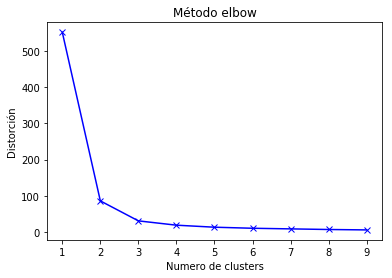

In [7]:
from sklearn.cluster import KMeans

distorcion=[]
K=range(1,10)

for k in K:
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(datos_petalos)
    distorcion.append(kmeans.inertia_)
    
plt.plot(K,distorcion, 'bx-')
plt.xlabel('Numero de clusters')
plt.ylabel('Distorción')
plt.title('Método elbow')
plt.show()

## Implementacion de k-means con sklearn

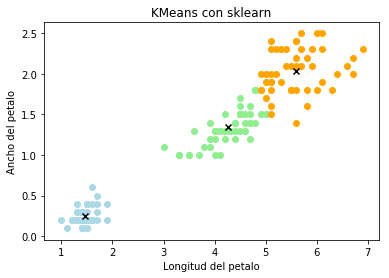

In [8]:
kmeans= KMeans(n_clusters=3)
modelo=kmeans.fit_predict(datos_petalos)

centroides=kmeans.cluster_centers_.T

#datos_petalos[modelo==0,0] le decimos grafica los puntos x donde mi modelo valga 0 
#datos_petalos[modelo==0,1] le decimos grafica los puntos y donde mi modelo valga 0 
plt.scatter(datos_petalos[modelo==0,0],datos_petalos[modelo==0,1], c='lightgreen')
plt.scatter(datos_petalos[modelo==1,0],datos_petalos[modelo==1,1], c='orange')
plt.scatter(datos_petalos[modelo==2,0],datos_petalos[modelo==2,1], c='lightblue')
plt.scatter(*centroides, marker='x', color='black')

plt.title('KMeans con sklearn')
plt.xlabel('Longitud del petalo')
plt.ylabel('Ancho del petalo')
plt.show()